In [3]:
import csv
import pandas as pd
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from image_database import *
from PIL import Image
from scipy.spatial.distance import cdist
import bisect 
from scipy.spatial import ConvexHull
import gc
import debias_clip as dclip
#import cvxpy as cp
image_folder_prefix = 'datasets/occupations_2/images/'

import sys
from PIL import Image


In [2]:
## Preprocessing
data = pd.read_csv('datasets/occupations_2/occupations_labels.csv') #datasets\occuptations_2\occupations_labels.csv
extract_term = lambda x: x.split('/')[0]
data['search_term'] = data['location'].apply(extract_term)

catagories = data['search_term'].unique()
define_path = lambda x: image_folder_prefix + x 
data['image_relative_path'] = data['location'].apply(define_path)

flawed_images = ["PR person/000056.jpg", "mail carrier/000067.jpg"]

data.drop(data[data['location'].isin(flawed_images)].index, inplace = True)

true_rate_women = {}
true_rate_dark = {}

for cat in catagories:
    data_in_cat = data[data['search_term'] == cat]
    true_rate_women[cat] = data_in_cat[data_in_cat['gender'] == 'Female'].count()[0]/data_in_cat.count()[0]
    true_rate_dark[cat] = data_in_cat[data_in_cat['skintone'] == 'dark'].count()[0]/data_in_cat.count()[0]
    data.loc[data['search_term'] == cat, 'search_p_women'] = true_rate_women[cat]
    data.loc[data['search_term'] == cat, 'search_p_dark'] = true_rate_dark[cat]

print(len(catagories))
print(data.shape)

96
(9598, 7)


In [3]:
data.head(10)


,location,gender,skintone,search_term,image_relative_path,search_p_women,search_p_dark
0,garbage collector/000001.jpg,Male,dark,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
1,garbage collector/000002.jpg,Male,light,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
2,garbage collector/000003.jpg,Male,dark,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
3,garbage collector/000004.jpg,Male,dark,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
4,garbage collector/000005.jpg,Male,dark,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
5,garbage collector/000006.jpg,NaN,NaN,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
6,garbage collector/000007.jpg,NaN,NaN,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
7,garbage collector/000008.jpg,Male,light,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
8,garbage collector/000009.jpg,Male,dark,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15
9,garbage collector/000010.jpg,Male,dark,garbage collector,datasets/occupations_2/images/garbage collecto...,0.08,0.15


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

batch_size = 200

if True:
    features = process_images(model, preprocess, data['image_relative_path'], batch_size=batch_size)



 17%|█▋        | 8/48 [00:48<04:15,  6.39s/it]c:\Anaconda\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 48/48 [08:23<00:00, 10.48s/it]


In [4]:
device_d = "cuda" if torch.cuda.is_available() else "cpu"
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

batch_size = 200

features_debias = process_images(model_debias, preprocess_debias, data['image_relative_path'], batch_size=batch_size, device=device_d)

device_d = 'cpu'
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 2.85MiB/s]
100%|██████████| 48/48 [07:52<00:00,  9.83s/it]


Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 4.88MiB/s]


In [5]:
print(features)

np.save('datasets/occupations_2/embeddings_of_labelled_images.npy', features)
np.save('datasets/occupations_2/embeddings_of_labelled_images_debias.npy', features_debias)

if False:
    features = np.load('datasets/occupations_2/embeddings_of_labelled_images.npy')


[[ 0.0842   0.533   -0.0644  ...  0.9097   0.05615 -0.00886]
 [-0.306    0.3274   0.2013  ...  0.8115  -0.2      0.2605 ]
 [ 0.0686   0.1488   0.101   ...  0.486    0.1422   0.331  ]
 ...
 [ 0.3772  -0.1936   0.297   ...  0.7603   0.0554  -0.0834 ]
 [-0.223   -0.1492   0.4485  ...  0.6636   0.0761   0.1573 ]
 [-0.01723 -0.2815  -0.1882  ...  0.2216   0.458   -0.02133]]


In [6]:
features = np.load('datasets/occupations_2/embeddings_of_labelled_images.npy')
features_debias = np.load('datasets/occupations_2/embeddings_of_labelled_images_debias.npy')

device_d = 'cpu'
model_debias, preprocess_debias = dclip.load("ViT-B/16-gender", device_d)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

Installing pretrained embedings
 best_ndkl_oai-clip-vit-b-16_neptune_run_OXVLB-317_model_e4_step_5334_embeddings.pt...


100%|█████████████████████████████████████| 4.73k/4.73k [00:00<00:00, 4.83MiB/s]


In [12]:
## Written referencing https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python
def process_images(image_addresses, max_size=(200, 200)):
    images = [Image.open(image_address) for image_address in image_addresses]
    for image in images:
        image.thumbnail(max_size)
    new_im = Image.new('RGB', (150 * 5, 300), color='white')
    x_offset = 0
    for i, im in enumerate(images):
        b = Image.new('RGB', (150, 150), 'black')
        if i <= len(images) // 2 - 1:
            new_im.paste(b, (x_offset, 0))
            new_im.paste(im, (x_offset, 0))
        else:
            new_im.paste(b, (x_offset, 150))
            new_im.paste(im, (x_offset, 150))
        x_offset += 150
        if i == len(images) // 2 - 1:
            x_offset = 0
    return new_im

image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of a young person", "A picture of an old person")])

print(data.head())
print(data['search_term'].unique())

print(image_database.features.dtype)
print(image_database.search("This is a picture of a pilot."))
pilot1 = image_database.search("This is a picture of a pilot.")
pilot2 = image_database.distinct_retrival("This is a picture of a pilot.", tol=.035)

p1c = process_images(pilot1['image_relative_path'])
p1c.save('results/graphics/pilot1.jpg')
p2c = process_images(pilot2['image_relative_path'])
p2c.save('results/graphics/pilot2.jpg')

l1 = image_database.search("This is a picture of a librarian.")
l2 = image_database.distinct_retrival("This is a picture of a librarian.", tol=.035)

l1c = process_images(l1['image_relative_path'])
l1c.save('results/graphics/librarian1.jpg')
l2c = process_images(l2['image_relative_path'])
l2c.save('results/graphics/librarian2.jpg')




                       location gender skintone        search_term  \
0  garbage collector/000001.jpg   Male     dark  garbage collector   
1  garbage collector/000002.jpg   Male    light  garbage collector   
2  garbage collector/000003.jpg   Male     dark  garbage collector   
3  garbage collector/000004.jpg   Male     dark  garbage collector   
4  garbage collector/000005.jpg   Male     dark  garbage collector   

                                 image_relative_path  search_p_women  \
0  datasets/occupations_2/images/garbage collecto...            0.08   
1  datasets/occupations_2/images/garbage collecto...            0.08   
2  datasets/occupations_2/images/garbage collecto...            0.08   
3  datasets/occupations_2/images/garbage collecto...            0.08   
4  datasets/occupations_2/images/garbage collecto...            0.08   

   search_p_dark  
0           0.15  
1           0.15  
2           0.15  
3           0.15  
4           0.15  
['garbage collector' 'dental hyg

0.3


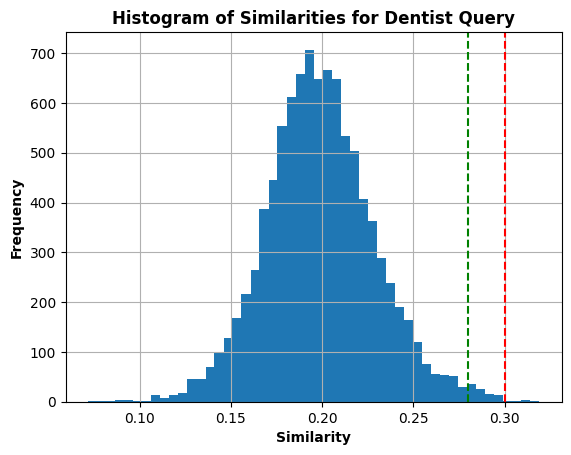

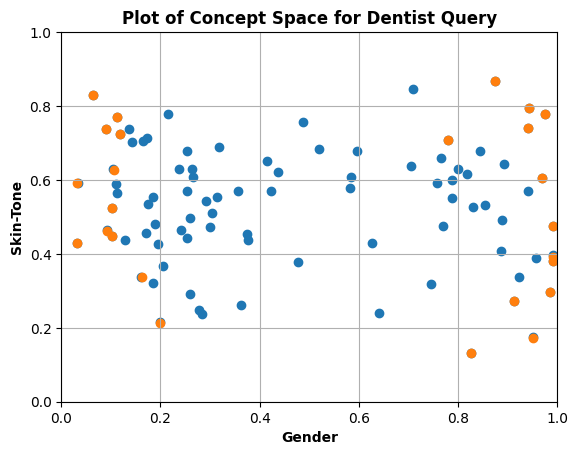

                         location  gender skintone       search_term  \
7522           dentist/000023.jpg    Male    light           dentist   
8866           cashier/000067.jpg  Female     dark           cashier   
5627            doctor/000028.jpg    Male    light            doctor   
173   dental hygienist/000074.jpg  Female    light  dental hygienist   
3761      exterminator/000062.jpg    Male    light      exterminator   
7593           dentist/000094.jpg  Female    light           dentist   
7532           dentist/000033.jpg    Male    light           dentist   
100   dental hygienist/000001.jpg  Female    light  dental hygienist   
2062           plumber/000063.jpg    Male    light           plumber   
7561           dentist/000062.jpg  Female    light           dentist   
7562           dentist/000063.jpg    Male    light           dentist   
7531           dentist/000032.jpg  Female    light           dentist   
7548           dentist/000049.jpg    Male    light           den

In [39]:
class ImageDatabase():
    def __init__(self, features, data, model, preprocess, device="cuda"):
        if device == "cuda": self.arraytype = torch.float16 
        else: self.arraytype = torch.float32
        self.features = t_normalize(torch.tensor(features).to(device)).to(self.arraytype)
        self.data = data
        self.model = model
        self.preprocess = preprocess
        self.device = device
        self.clipclip_orderings = {}

    def _process_query(self, query):
        token = clip.tokenize(query).to(self.device)
        #print(token.device)
        with torch.no_grad():
            query_features = t_normalize(self.model.encode_text(token))
        return query_features
        
    def search(self, query, k=10, **kwargs):
        query_features = self._process_query(query)
        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()
        return self.data.iloc[best[:k]], similarities 
    
    def sensitive_attributes(self, paired_attributes):
        l_attr = list(sum(paired_attributes, ()))
        tokens = clip.tokenize(l_attr).to(self.device)
        with torch.no_grad():
            attributes_features = t_normalize(self.model.encode_text(tokens))
        self.sensitive_ideals = attributes_features.reshape(len(paired_attributes), 2, -1)

        return self
        
    def _calc_sim_set(self, best, similarities, k, max_sim_set, tol):
        sim = similarities[best]
        sim_top_k_avg = sim[0:k].mean()
        for i in range(len(sim)):
            if sim[i] < sim_top_k_avg - tol:
                break
        k = min(max(k, i), max_sim_set)
        return best[0:k]


    def _get_sim_to_ideal(self, entries):
        sim_set_features = self.features[entries]
        sim = torch.matmul(self.sensitive_ideals, sim_set_features.T)
        proba = (100 * sim).permute(2, 0, 1).softmax(dim=-1)[:, :, 0].to('cpu').numpy()
        return proba

    def _retrieve_distinct(self, sim_set, similarities, k, mode='max_sum'):
        proba_concepts = self._get_sim_to_ideal(sim_set)
        vals = proba_concepts
        pca = PCA()
        
        if mode == 'max_sum': 
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)
        
        if mode == 'euc_max_sum': 
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'euclidean')

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'euclidean')))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'max_min':
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                min_distances = np.min(distances, axis=1)
                max_min = np.argmax(min_distances)
                maximally_away = max_min
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)
        
        if mode == 'euc_max_min':
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'euclidean')

            while len(p) < k:
                min_distances = np.min(distances, axis=1)
                max_min = np.argmax(min_distances)
                maximally_away = max_min
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'euclidean')))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'random':
            p_indices = np.random.choice(sim_set, k, replace = False)
            
            
        if mode == "feature_distances":
            vals = torch.index_select(self.features, 0, sim_set.to(self.device)).cpu().numpy()
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'cosine')

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'cosine')))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        if mode == 'true_labels':
            vals = self._get_true_coordinates(sim_set)
            VI=np.cov(vals, rowvar=False)
            sim_set_edit = sim_set.detach().clone().numpy()
            p_indices = [sim_set_edit[0]]
            sim_set_edit = np.delete(sim_set_edit, 0)
            p = [vals[0]]
            vals = np.delete(vals, 0, axis=0)

            distances = cdist(vals, p, 'mahalanobis', VI=VI)

            while len(p) < k:
                mean_distances = np.mean(distances, axis=1)
                max_sum = np.argmax(mean_distances)
                maximally_away = max_sum
                p_indices.append(sim_set_edit[maximally_away])
                p.append(vals[maximally_away])
                distances = np.hstack((distances, cdist(vals, [vals[maximally_away]], 'mahalanobis', VI=VI)))
                sim_set_edit = np.delete(sim_set_edit, maximally_away)
                vals = np.delete(vals, maximally_away, axis=0)
                distances = np.delete(distances, maximally_away, axis=0)

        return p_indices
    
    def define_coordinate_mapping(self, columns, positive_labels, negative_labels):
        self.true_coordinates = np.zeros((len(self.data), len(columns)))
        self.coord_columns = columns
        for i, column in enumerate(columns):
            map_to_hypercube = lambda x: 1 if x in positive_labels[i] else (0 if x in negative_labels[i] else .5)
            self.true_coordinates[:, i] = self.data[column].apply(map_to_hypercube)
    
    def _get_true_coordinates(self, sim_set):
        return self.true_coordinates[sim_set] 

    
    def distinct_retrival(self, query, k=10, max_sim_set=1000, tol=.06, method='max_sum', **kwargs) :
        query_features = self._process_query(query)

        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()

        sim_set = self._calc_sim_set(best, similarities, k, max_sim_set, tol)
        distinct_sort = self._retrieve_distinct(sim_set, similarities, k, mode=method)

        coords = self._get_sim_to_ideal(sim_set)
    
        return self.data.iloc[distinct_sort], coords, self._get_sim_to_ideal(distinct_sort), self._get_sim_to_ideal(best[0:k])

    def define_pbm_classes(self, classes):
        self.pbm_classes=classes
        prompts = [f"A picture of a {c}." for c in classes]
        if classes[0] == "empty":
            prompts[0] == ""
        tokens = clip.tokenize(prompts).to(self.device)
        with torch.no_grad():
            attributes_features = t_normalize(self.model.encode_text(tokens))
        self.pbm_ideals = attributes_features
        self.pbm_label = np.argmax((100 * torch.matmul(self.features, self.pbm_ideals.T)).softmax(dim=-1).to('cpu').numpy(), axis=-1)

        return self

    def pbm(self, query, k=10, eps=0, **kwargs):
        query_features = self._process_query(query)
        similarities = (self.features @ query_features.T).flatten()
        best = similarities.argsort(descending=True).cpu().numpy().flatten()
        np_sim = similarities.cpu().numpy()

        p_indices = []

        neutrals = [x for x in best if self.pbm_label[x] == 0]
        classes = [[x for x in best if self.pbm_label[x]== i] for i in range(1, len(self.pbm_classes))]

    
        while len(p_indices) < k:
            if random.random() < eps:
                try:
                    neutral_sim = np_sim[neutrals[0]]
                except:
                    neutral_sim = -1
                
                max_class, idx = 0, 0
                for i, c in enumerate(classes):
                    try:
                        class_sim = np_sim[c[0]]
                    except:
                        class_sim = -1
                    if class_sim > max_class:
                        max_class = class_sim
                        idx = i
                if max_class > neutral_sim:
                    p_indices.append(classes[idx][0])
                    classes[idx].pop(0)
                else:
                    p_indices.append(neutrals[0])
                    neutrals.pop(0)
                        
            else:
                best_neutral = neutrals[0]
                best_for_classes = [fon(c) for c in classes]
                best_for_classes_vals = [c for c in best_for_classes if c is not None]

                similarities_for_classes = [np_sim[x] for x in best_for_classes_vals]
                avg_sim = np.mean(similarities_for_classes)
                neutral_sim = similarities[best_neutral]

                if avg_sim > neutral_sim:
                    if len(p_indices) + len(best_for_classes_vals) > k:
                        best_for_classes_vals = random.choices(best_for_classes_vals, k=k-len(p_indices))
                    p_indices += best_for_classes_vals

                    for i, x in enumerate(best_for_classes):
                        if x is not None:
                            classes[i].pop(0)
                else:
                    p_indices.append(best_neutral)
                    neutrals.pop(0)
        
        return self.data.iloc[p_indices]

    def add_clipclip_ordering(self, name, ordering):
        self.clipclip_orderings[name] = ordering.copy()
        return self
    
    def clip_clip(self, query, ordering, n_to_clip, k=10, **kwargs):
        query_features = self._process_query(query)
        clip_ordering = self.clipclip_orderings[ordering]
        clip_features = torch.index_select(self.features, 1, torch.tensor(clip_ordering[n_to_clip:]).to(self.device))
        clip_query = torch.index_select(query_features, 1, torch.tensor(clip_ordering[n_to_clip:]).to(self.device))

        similarities = (clip_features @ clip_query.T).flatten()
        best = similarities.argsort(descending=True).cpu().flatten()
        return self.data.iloc[best[:k]]
    
image_database = ImageDatabase(features, data, model, preprocess, device)
image_database.sensitive_attributes([("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])

res, sim = image_database.search("This is a picture of a Dentist.", k=25)
hp = sim.sort(descending=True).values[0:25].mean().cpu().numpy()
print(hp)

plt.hist(sim.cpu().numpy(), bins=50)
plt.axvline(x=hp, color='red', linestyle='--')
plt.axvline(x=hp-.02, color='green', linestyle='--')
plt.xlabel('Similarity', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title('Histogram of Similarities for Dentist Query', weight='bold')
plt.grid()
plt.show()


res, coords, P, tk = image_database.distinct_retrival("This is a picture of a Dentist.", tol=.02, k=25, method='max_sum')

plt.scatter(coords[:, 0], coords[:, 1], label='Images in Sim Set')
plt.scatter(P[:,0], P[:, 1], label='Returned Images')
#plt.scatter(tk[:,0], tk[:, 1], label='Top K Images', alpha=.3)
plt.xlabel("Gender", weight='bold')
plt.ylabel("Skin-Tone", weight='bold')
plt.title("Plot of Concept Space for Dentist Query", weight='bold')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(res)



In [42]:
image_database = ImageDatabase(features, data, model, preprocess, device)
indistinguisable_values = [[cat] for cat in catagories]
totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
true_rates = [[data[data['search_term'] == cat].iloc[0].search_p_women for cat in catagories], [data[data['search_term'] == cat].iloc[0].search_p_dark for cat in catagories]]
image_database.define_coordinate_mapping(['gender', 'skintone'], [['man'], ['light']], [['woman'], ['dark']])

debias_database = ImageDatabase(features_debias, data, model_debias, preprocess_debias, device_d)

image_database.add_clipclip_ordering("gender", np.load('datasets/MI_orders/gender.npy'))
image_database.add_clipclip_ordering("skintone", np.load('datasets/MI_orders/skintone.npy'))
image_database.add_clipclip_ordering("intersectional", np.load('datasets/MI_orders/gender_skintone.npy'))
image_database.add_clipclip_ordering("three_attr", np.load('datasets/MI_orders/intersectional.npy'))


method_name_specification_list = [
    (lambda k, tol: lambda x: image_database.search(x, k), 'Baseline', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_4_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person"), ("A picture of an American person", "A picture of a non-American person")])]),

    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_gender', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_skintone', [("sensitive_attributes", [("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_4_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person"), ("A picture of an American person", "A picture of a non-American person")])]),

    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='random'), 'CDI_Random', [("sensitive_attributes", [("A picture of a man", "A picture of a woman")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='feature_distances'), 'CDI_Features', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='true_labels'), 'CDI_TrueConcept', []),
    
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_gender', [("pbm_classes", ["unknown gender", "man", "woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_intersectional', [("pbm_classes", ["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_skintone', [("pbm_classes", ["unknown skin-tone", "light-skinned person", "dark-skinned person"])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_three_attributes', [("pbm_classes", intersections_for_pbm([["light-skinned", "dark-skinned"], ["old", "young"], ["man", "woman"]], "an unknown skin-tone, age, and gender", ""))]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_four_attributes', [("pbm_classes", intersections_for_pbm([["light-skinned", "dark-skinned"], ["old", "young"], ["American", "non-American"], ["man", "woman"]], "an unknown skin-tone, age, nationality, and gender", ""))]),
    
    (lambda k, n: lambda x: image_database.clip_clip(x, "gender", n, k), 'CLIP_gender', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "skintone", n, k), 'CLIP_skintone', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "intersectional", n, k), 'CLIP_intersectional', []),
    (lambda k, n: lambda x: image_database.clip_clip(x, "three_attr", n, k), 'CLIP_three_attributes', []),

    (lambda k, tol: lambda x: debias_database.search(x, k), 'DebiasClip', []),

    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])])
]



all_sensitive_pairs = [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person"), ("A picture of an American person", "A picture of a non-American person"), ("A picture of a abled-bodied person", "A picture of a disabled person"), ("A picture of a religious person", "A picture of a non-religious person"), ("A picture of a veteran", "A picture of someone who is not a veteran"), ("A picture of a straight person", "A picture of a LGBT person")]
overconcepted_pairs = [("A picture of a man", "A picture of a woman"), ("A picture of someone masculine", "A picture of someone feminine"), ("A picture of a male", "A picture of a female"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")]

method_name_specification_list = [
    (lambda k, tol: lambda x: image_database.search(x, k), 'Baseline', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_6_attr', [("sensitive_attributes", all_sensitive_pairs[:6])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_8_attr', [("sensitive_attributes", all_sensitive_pairs)]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_6_attr', [("sensitive_attributes", all_sensitive_pairs[:6])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_8_attr', [("sensitive_attributes", all_sensitive_pairs)]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_6_attr', [("sensitive_attributes", all_sensitive_pairs[:6])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_8_attr', [("sensitive_attributes", all_sensitive_pairs)]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_3_attr', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person"), ("A picture of an old person", "A picture of a young person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_6_attr', [("sensitive_attributes", all_sensitive_pairs[:6])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_8_attr', [("sensitive_attributes", all_sensitive_pairs)]),


    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_overconcept', [("sensitive_attributes", overconcepted_pairs)]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_overconcept', [("sensitive_attributes", overconcepted_pairs)]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_min'), 'CDI_EucMin_overconcept', [("sensitive_attributes", overconcepted_pairs)]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='euc_max_sum'), 'CDI_EucSum_overconcept', [("sensitive_attributes", overconcepted_pairs)]),

]

method_name_specification_list = [
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_five_attributes', [("pbm_classes", intersections_for_pbm([["light-skinned", "dark-skinned"], ["old", "young"], ["American", "non-American"], ["abled-bodied", "disabled"], ["man", "woman"]], "an unknown skin-tone, age, nationality, disability status, and gender", ""))]),

]


ks = [10, 25, 50, 100] # [10, 25, 50, 100] 

number_of_tol_steps = 16 # 16
number_of_eps_steps = 11 # 11
number_of_clip_clip_steps = 24 #24
random_iters = 4

result_dicts = []

for method, name, spec in method_name_specification_list:
    print(f"Starting analysis for method: {name}...")
    for s, val in spec:
        if s == "sensitive_attributes":
            image_database.sensitive_attributes(val)
        if s == "pbm_classes":
            image_database.define_pbm_classes(val)
    for k in tqdm(ks):
        result_dict = {'name': name}

        if name in ['Baseline', "DebiasClip"]:
            steps = 1
        else:
            steps = number_of_tol_steps

        if name[0:3] == 'PBM':
            for e in reversed(range(0, number_of_eps_steps)):
                eps = e / (number_of_eps_steps - 1)
                retrieval_function = method(k, eps)
                new_dict = result_dict.copy()
                random_results = []
                for i in range(random_iters):
                    new_dict = result_dict.copy()
                    run_analysis(retrieval_function, k, eps, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                    random_results.append(new_dict)
                
                add_dict = result_dict.copy()
                for key in random_results[0].keys():
                    if key == 'name':
                        continue
                    add_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                result_dicts.append(add_dict)

        elif name[0:4] == 'CLIP':
            for e in range(0, number_of_clip_clip_steps):
                n = e * 20
                retrieval_function = method(k, n)
                new_dict = result_dict.copy()
                run_analysis(retrieval_function, k, n, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)
        else:
            for t in range(0, steps):
                if steps == 1:
                    tol = None
                else:
                    tol = t / 200
                retrieval_function = method(k, tol)
                new_dict = result_dict.copy()
                if name == "CDI_Random":
                    random_results = []
                    for i in range(random_iters):
                        new_dict = result_dict.copy()
                        run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values,  ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                        random_results.append(new_dict)
                    new_dict = result_dict.copy()

                    for key in random_results[0].keys():
                        if key == 'name':
                            continue
                        new_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                else:
                    run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                result_dicts.append(new_dict)

df = parse_analysis(result_dicts, ['gender', 'skintone'])

print(df)

df.to_pickle("results/occ2-pbm-five-concepts.pkl")
        

Starting analysis for method: PBM_five_attributes...


  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
def plot_across_tol(df, k, method_names, axis1, axis2, xlabel=None, ylabel=None, title=None, reverse_x = False):
    relevant_k = df[df['k'] == k]

    for method in method_names:
        data_for_method = relevant_k[relevant_k['name'] == method]
        d1 = data_for_method[axis1]
        d2 = data_for_method[axis2]

        if method in ["Baseline", "DebiasClip"]:
            plt.scatter(d1, d2, label=method)
        else:
            plt.plot(d1, d2, label=method)
    plt.legend()
    if xlabel is not None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(axis1)
    if ylabel is not None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(axis2)
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"Graph of {axis2} over {axis1} @ {k}")
    if reverse_x:
        plt.gca().invert_xaxis()
    plt.grid()
    plt.show()


In [ ]:
#method_names = df['name'].unique()
df = pd.read_pickle("results/occ2-3-23.pkl")

method_names = ['DebiasClip', 'CDI_Min_intersectional', 'CDI_Sum_intersectional', 'CDI_Min_4_attr', 'CDI_Sum_4_attr', 'PBM_intersectional', 'CLIP_intersectional', 'PBM_four_attributes', 'Baseline']

for k in [10, 25, 50, 100]:
    plot_across_tol(df, k, method_names, 'Avg_AbsBias_gender', 'Avg_Precision', reverse_x=True)
    #plot_across_tol(df, k, method_names, 'Avg_Bias_gender', 'Avg_Precision', reverse_x=False)
    #plot_across_tol(df, k, method_names, 'Avg_Skew_gender', 'Avg_Precision', reverse_x=False)
    #plot_across_tol(df, k, method_names, 'Avg_AbsBias_gender', 'Avg_Recall', reverse_x=True)
    #plot_across_tol(df, k, method_names, 'Avg_Bias_gender', 'Avg_Recall', reverse_x=False)
    plot_across_tol(df, k, method_names, 'Avg_AbsBias_for_Accurate_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df, k, method_names, 'Avg_Max_MC_Bias', 'Avg_Precision', reverse_x=True)

In [23]:
method_names = df['name'].unique().tolist()
print(df)
df2 = pd.read_pickle("results/occ2-3-23.pkl")
print(df2)
df3 = pd.concat([df2, df])

                                     method                       name    tol  \
0              CDI_EucSum_3_attr (tol: 0.0)          CDI_EucSum_3_attr  0.000   
1            CDI_EucSum_3_attr (tol: 0.005)          CDI_EucSum_3_attr  0.005   
2             CDI_EucSum_3_attr (tol: 0.01)          CDI_EucSum_3_attr  0.010   
3            CDI_EucSum_3_attr (tol: 0.015)          CDI_EucSum_3_attr  0.015   
4             CDI_EucSum_3_attr (tol: 0.02)          CDI_EucSum_3_attr  0.020   
..                                      ...                        ...    ...   
251  CDI_EucMin_intersectional (tol: 0.055)  CDI_EucMin_intersectional  0.055   
252   CDI_EucMin_intersectional (tol: 0.06)  CDI_EucMin_intersectional  0.060   
253  CDI_EucMin_intersectional (tol: 0.065)  CDI_EucMin_intersectional  0.065   
254   CDI_EucMin_intersectional (tol: 0.07)  CDI_EucMin_intersectional  0.070   
255  CDI_EucMin_intersectional (tol: 0.075)  CDI_EucMin_intersectional  0.075   

       k  Avg_Precision  Av

In [ ]:
print(df3)
method_names += ['CDI_Sum_intersectional', 'CDI_Min_intersectional', 'CDI_Sum_3_attr', 'CDI_Min_3_attr']

for k in [10, 25, 50, 100]:
    plot_across_tol(df3, k, method_names, 'Avg_AbsBias_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df3, k, method_names, 'Avg_Bias_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df3, k, method_names, 'Avg_Skew_gender', 'Avg_Precision', reverse_x=False)
    plot_across_tol(df3, k, method_names, 'Avg_AbsBias_gender', 'Avg_Recall', reverse_x=True)
    plot_across_tol(df3, k, method_names, 'Avg_Bias_gender', 'Avg_Recall', reverse_x=False)
    plot_across_tol(df3, k, method_names, 'Avg_AbsBias_for_Accurate_gender', 'Avg_Precision', reverse_x=True)
    plot_across_tol(df3, k, method_names, 'Avg_Max_MC_Bias', 'Avg_Precision', reverse_x=True)

{'garbage collector': 100, 'dental hygienist': 100, 'paralegal': 100, 'courier': 100, 'housekeeper': 100, 'carpenter': 100, 'nurse practitioner': 100, 'building painter': 100, 'building inspector': 100, 'barber': 100, 'lawyer': 100, 'tour guide': 100, 'logistician': 100, 'pharmacist': 100, 'bartender': 100, 'librarian': 100, 'tax collector': 100, 'hairdresser': 100, 'engineer': 100, 'flight attendant': 100, 'plumber': 100, 'biologist': 100, 'parking attendant': 100, 'claims adjuster': 100, 'truck driver': 100, 'cook': 100, 'counselor': 100, 'drafter': 100, 'photographer': 100, 'financial advisor': 100, 'baker': 100, 'chiropractor': 100, 'insurance sales agent': 100, 'architect': 100, 'groundskeeper': 100, 'taxi driver': 100, 'tax preparer': 100, 'exterminator': 100, 'veterinarians': 100, 'nurse': 100, 'dishwasher': 100, 'real estate agent': 100, 'announcer': 100, 'bill collector': 100, 'private investigator': 100, 'receptionist': 100, 'typist': 100, 'travel agent': 100, 'teller': 100, 

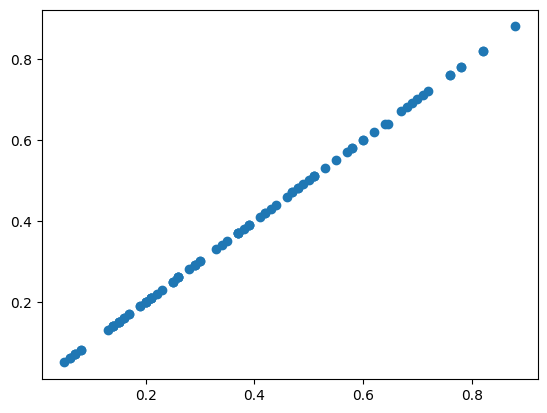

In [55]:
print(totals_by_cat)

recalls = []
precisions = []
for cat in catagories:
    res = image_database.clip_clip(f"This is a picture of a {cat}", "intersectional", 100, k=100)
    recalls.append(recall(label_column='search_term', positive_label_value=cat, data=res, total_positive=totals_by_cat[cat]))
    precisions.append(precision(label_column='search_term', positive_label_value=cat, data=res))

plt.scatter(recalls, precisions)
plt.show()

In [ ]:
attr = [("A picture of a man", "A picture of a woman"), ("A picture of a white person", "A picture of a black person"), ("A picture of a young person", "A picture of an old person"), ("A picture of an American Person", "A picture of a non-American person"), ("A picture of a disabled person", "A picture of a person who is not disabled")]
image_database = ImageDatabase(features, data, model, preprocess, device)
k = [10, 25, 50]
number_of_tol_steps = 20

for k in k:
    precisions, biases, skews = {}, {}, {}
    for i in range(len(attr)):
        avg_precision = []
        avg_bias = []
        image_database.sensitive_attributes(attr[:i+1])
        for tol in range(0, number_of_tol_steps):
            baseline_metrics = {}
            t = tol / (10 * (number_of_tol_steps-1))
            run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method='max_sum'), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates)
            avg_bias.append(np.mean(baseline_metrics['abs_bias'], axis=0))
            avg_precision.append(np.mean(baseline_metrics['precision']))
        precisions[str(i)] = avg_precision
        biases[str(i)] = avg_bias


    baseline_metrics = {}
    run_analysis(lambda x: image_database.search(x, k), k, None, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates)
    baseline_precision = np.mean(baseline_metrics['precision'])
    baseline_bias = np.mean(baseline_metrics['abs_bias'], axis=0)
    baseline_skew = np.mean(baseline_metrics['skew'])

    for i in range(len(attr)):
        plt.plot(unpack_to_i(biases[str(i)], 0), precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(unpack_to_i(baseline_bias, 0), baseline_precision, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias on Gender")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

    
    for i in range(len(attr)):
        plt.plot(unpack_to_i(biases[str(i)], 1), precisions[str(i)], label=("Total unmeasured cats: " + str(i)))
    plt.scatter(unpack_to_i(baseline_bias, 1), baseline_precision, label='Baseline')
    plt.grid()
    plt.xlabel("Average AbsBias on Skin-Tone")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()

            

In [ ]:
attributes = [
    [("A picture of a man.", "A picture of a woman."), ("A picture of a white person", "A picture of a black person")],
    [("A picture of a man.", "A picture of a woman."), ("A picture of a white person", "A picture of a black person"), ("A picture of a white person", "A picture of a hispanic person"), ("A picture of a white person", "A picture of an asian person"), ("A picture of a white person", "A picture of a mixed-race person"), ("A picture of a white person", "A picture of a native-american person or pacific islander")],
    [("A picture of a man.", "A picture of a woman."), ("A picture of a light-skinned person", "A picture of a dark-skinned person")]
]

labels = [
    "White vs Black",
    "Different Ethnicities",
    "Skin-tone"
]

k = [10, 25, 50]
number_of_tol_steps = 15

for k in k:
    precisions, biases, skews = {}, {}, {}
    for i in range(len(attributes)):
        avg_precision = []
        avg_bias = []
        image_database.sensitive_attributes(attributes[i])
        for tol in tqdm(range(0, number_of_tol_steps)):
            baseline_metrics = {}
            t = tol / (10 * (number_of_tol_steps-1))
            run_analysis(lambda x: image_database.distinct_retrival(x, k, tol=t, method='max_sum'), k, t, baseline_metrics, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates)
            avg_bias.append(np.mean(baseline_metrics['abs_bias'], axis=0))
            avg_precision.append(np.mean(baseline_metrics['precision']))
        precisions[str(i)] = avg_precision
        biases[str(i)] = avg_bias

    for i in range(len(attributes)):
        plt.plot(unpack_to_i(biases[str(i)], 1), precisions[str(i)], label=(labels[i]))
    plt.grid()
    plt.xlabel("Average AbsBias on Skin-Tone")
    plt.ylabel("Average Precision")
    plt.gca().invert_xaxis()
    plt.title(f"Precision-AbsBias Curve @ {k}")
    plt.legend()
    plt.show()


In [10]:
method_name_specification_list = [
    (lambda k, tol: lambda x: image_database.search(x, k), 'Baseline', []),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_sum'), 'CDI_Sum_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, tol: lambda x: image_database.distinct_retrival(x, k, tol=tol, method='max_min'), 'CDI_Min_intersectional', [("sensitive_attributes", [("A picture of a man", "A picture of a woman"), ("A picture of a light-skinned person", "A picture of a dark-skinned person")])]),
    (lambda k, eps: lambda x: image_database.pbm(x, k, eps=eps), 'PBM_intersectional', [("pbm_classes", ["unknown gender and skin-tone", "light-skinned man", "light-skinned woman", "dark-skinned man", "dark-skinned woman"])]),
    (lambda k, n: lambda x: image_database.clip_clip(x, "intersectional", n, k), 'CLIP_intersectional', []),
    (lambda k, tol: lambda x: debias_database.search(x, k), 'DebiasClip', [])
]
np.random.seed(123)
result_dicts = []
for runs in range(5):
    r_indexs = np.random.choice(len(data), int(len(data) * .7), replace=False)
    f_random = features[r_indexs]
    d_random = data.iloc[r_indexs]
    fd_random = features_debias[r_indexs]
    image_database = ImageDatabase(f_random, d_random, model, preprocess, device)
    indistinguisable_values = [[cat] for cat in catagories]
    totals_by_cat = {cat: len(data[data['search_term'] == cat]) for cat in catagories}
    true_rates = [[data[data['search_term'] == cat].iloc[0].search_p_women for cat in catagories], [data[data['search_term'] == cat].iloc[0].search_p_dark for cat in catagories]]
    image_database.define_coordinate_mapping(['gender', 'skintone'], [['man'], ['light']], [['woman'], ['dark']])
    
    debias_database = ImageDatabase(fd_random, d_random, model_debias, preprocess_debias, device_d)
    image_database.add_clipclip_ordering("intersectional", np.load('datasets/MI_orders/gender_skintone.npy'))

    ks = [10, 25, 50, 100] # [10, 25, 50, 100] 

    number_of_tol_steps = 16 # 16
    number_of_eps_steps = 11 # 11
    number_of_clip_clip_steps = 24 #24
    random_iters = 4

    for method, name, spec in method_name_specification_list:
        print(f"Starting analysis for method: {name}...")
        for s, val in spec:
            if s == "sensitive_attributes":
                image_database.sensitive_attributes(val)
            if s == "pbm_classes":
                image_database.define_pbm_classes(val)
        for k in tqdm(ks):
            result_dict = {'name': name}

            if name in ['Baseline', "DebiasClip"]:
                steps = 1
            else:
                steps = number_of_tol_steps

            if name[0:3] == 'PBM':
                for e in reversed(range(0, number_of_eps_steps)):
                    eps = e / (number_of_eps_steps - 1)
                    retrieval_function = method(k, eps)
                    new_dict = result_dict.copy()
                    random_results = []
                    for i in range(random_iters):
                        new_dict = result_dict.copy()
                        run_analysis(retrieval_function, k, eps, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                        random_results.append(new_dict)
                    
                    add_dict = result_dict.copy()
                    for key in random_results[0].keys():
                        if key == 'name':
                            continue
                        add_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                    result_dicts.append(add_dict)

            elif name[0:4] == 'CLIP':
                for e in range(0, number_of_clip_clip_steps):
                    n = e * 20
                    retrieval_function = method(k, n)
                    new_dict = result_dict.copy()
                    run_analysis(retrieval_function, k, n, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                    result_dicts.append(new_dict)
            else:
                for t in range(0, steps):
                    if steps == 1:
                        tol = None
                    else:
                        tol = t / 200
                    retrieval_function = method(k, tol)
                    new_dict = result_dict.copy()
                    if name == "CDI_Random":
                        random_results = []
                        for i in range(random_iters):
                            new_dict = result_dict.copy()
                            run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values,  ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                            random_results.append(new_dict)
                        new_dict = result_dict.copy()

                        for key in random_results[0].keys():
                            if key == 'name':
                                continue
                            new_dict[key] = np.mean([res[key] for res in random_results], axis=0)
                    else:
                        run_analysis(retrieval_function, k, tol, new_dict, catagories, 'search_term', indistinguisable_values, ['gender', 'skintone'], [['Female'], ['dark']], [['Male'], ['light']], true_rates, totals_by_cat)
                    result_dicts.append(new_dict)

df = parse_analysis(result_dicts, ['gender', 'skintone'])

df.to_pickle("results/occ2-3-29-validation.pkl")





Starting analysis for method: Baseline...


100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Starting analysis for method: CDI_Sum_intersectional...


100%|██████████| 4/4 [33:30<00:00, 502.67s/it]


Starting analysis for method: CDI_Min_intersectional...


100%|██████████| 4/4 [33:08<00:00, 497.09s/it]


Starting analysis for method: PBM_intersectional...


100%|██████████| 4/4 [12:31<00:00, 187.76s/it]


Starting analysis for method: CLIP_intersectional...


100%|██████████| 4/4 [03:11<00:00, 47.79s/it]


Starting analysis for method: DebiasClip...


100%|██████████| 4/4 [00:36<00:00,  9.12s/it]


Starting analysis for method: Baseline...


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Starting analysis for method: CDI_Sum_intersectional...


100%|██████████| 4/4 [30:10<00:00, 452.69s/it]


Starting analysis for method: CDI_Min_intersectional...


100%|██████████| 4/4 [27:39<00:00, 414.96s/it]


Starting analysis for method: PBM_intersectional...


100%|██████████| 4/4 [12:40<00:00, 190.21s/it]


Starting analysis for method: CLIP_intersectional...


100%|██████████| 4/4 [03:12<00:00, 48.17s/it]


Starting analysis for method: DebiasClip...


100%|██████████| 4/4 [00:33<00:00,  8.41s/it]


Starting analysis for method: Baseline...


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]


Starting analysis for method: CDI_Sum_intersectional...


100%|██████████| 4/4 [31:55<00:00, 478.88s/it]


Starting analysis for method: CDI_Min_intersectional...


100%|██████████| 4/4 [24:42<00:00, 370.50s/it]


Starting analysis for method: PBM_intersectional...


100%|██████████| 4/4 [12:34<00:00, 188.50s/it]


Starting analysis for method: CLIP_intersectional...


100%|██████████| 4/4 [03:13<00:00, 48.39s/it]


Starting analysis for method: DebiasClip...


100%|██████████| 4/4 [00:35<00:00,  9.00s/it]


Starting analysis for method: Baseline...


100%|██████████| 4/4 [00:07<00:00,  1.86s/it]


Starting analysis for method: CDI_Sum_intersectional...


100%|██████████| 4/4 [23:38<00:00, 354.72s/it]


Starting analysis for method: CDI_Min_intersectional...


100%|██████████| 4/4 [23:25<00:00, 351.47s/it]


Starting analysis for method: PBM_intersectional...


100%|██████████| 4/4 [12:41<00:00, 190.31s/it]


Starting analysis for method: CLIP_intersectional...


100%|██████████| 4/4 [03:04<00:00, 46.14s/it]


Starting analysis for method: DebiasClip...


100%|██████████| 4/4 [00:43<00:00, 10.75s/it]


Starting analysis for method: Baseline...


100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Starting analysis for method: CDI_Sum_intersectional...


100%|██████████| 4/4 [25:08<00:00, 377.15s/it]


Starting analysis for method: CDI_Min_intersectional...


100%|██████████| 4/4 [25:18<00:00, 379.57s/it]


Starting analysis for method: PBM_intersectional...


100%|██████████| 4/4 [12:24<00:00, 186.05s/it]


Starting analysis for method: CLIP_intersectional...


100%|██████████| 4/4 [03:09<00:00, 47.28s/it]


Starting analysis for method: DebiasClip...


100%|██████████| 4/4 [00:35<00:00,  8.81s/it]
